In [ ]:
pip install pythainlp


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.3/19.3 MB 85.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
# from nltk.tokenize import word_tokenize
from pythainlp.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer

from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.optimizers import Adam

import seaborn as sn
import matplotlib.pyplot as plt

import pickle as p
import plotly
import plotly.graph_objs as go

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report

import aiohttp
import asyncio

API_SENTIMENT_URL = "https://api.aiforthai.in.th/ssense"
API_BULLY_URL = "https://api.aiforthai.in.th/bully"
API_KEY = "MLmi4VDme8ONK91lcqSUkc90vqqK7TgU"

RETRY_DELAY = 3
MAX_RETRIES = 10

async def analyze_sentiment(session, comment):
    """วิเคราะห์ sentiment (pos, neu, neg)"""
    headers = {"Apikey": API_KEY}
    params = {"text": comment}

    for _ in range(MAX_RETRIES):
        try:
            async with session.get(API_SENTIMENT_URL, headers=headers, params=params) as response:
                if response.status == 200:
                    result = await response.json()
                    sentiment = result.get("sentiment", {}).get("polarity", "neutral")
                    return sentiment[:3] if sentiment in ["positive", "negative", "neutral"] else "neu"
        except Exception as e:
            print(f"❌ Error in sentiment API: {e}")
        await asyncio.sleep(RETRY_DELAY)

    return "neu"

async def analyze_bully(session, comment):
    """ตรวจสอบคำหยาบและบูลลี่"""
    headers = {"Apikey": API_KEY}
    params = {"text": comment}

    for _ in range(MAX_RETRIES):
        try:
            async with session.get(API_BULLY_URL, headers=headers, params=params) as response:
                if response.status == 200:
                    result = await response.json()
                    bully_type = result.get("bully_type", [])

                    if not bully_type or 0 in bully_type:
                        return "neg"

                    if any(bt in [2, 6] for bt in bully_type):  # คำหยาบ, ข่มขู่
                        return "hig"

                    if any(bt in [1, 3, 4, 5] for bt in bully_type):  # บูลลี่
                        return "bly"

        except Exception as e:
            print(f"❌ Error in bully API: {e}")
        await asyncio.sleep(RETRY_DELAY)

    return "neg"

async def analyze_comment(session, comment):
    """รวมการวิเคราะห์ sentiment และคำหยาบ"""
    sentiment = await analyze_sentiment(session, comment)

    if sentiment == "neg":
        return await analyze_bully(session, comment)
    return sentiment

async def process_comments():
    """อ่านไฟล์ train.txt และวิเคราะห์ข้อความ"""
    label_counts = {"pos": 0, "neu": 0, "neg": 0, "hig": 0, "bly": 0}

    with open("train.txt", "r", encoding="utf-8") as file:
        comments = [line.strip() for line in file if line.strip()]

    async with aiohttp.ClientSession() as session:
        tasks = [analyze_comment(session, comment) for comment in comments]
        results = await asyncio.gather(*tasks)

    with open("train_label.txt", "w", encoding="utf-8") as file:
        for result in results:
            file.write(f"{result}\n")
            if result in label_counts:
                label_counts[result] += 1

    print(f"✅ วิเคราะห์เสร็จแล้ว! ผลลัพธ์บันทึกที่ train_label.txt")
    for label, count in label_counts.items():
        print(f"จำนวน {label}: {count} คำ")

# รันโปรแกรม
await process_comments()

In [ ]:
EPOCHS = 300
BS = 16

In [ ]:
comments = []
labels = []

with open("train_cleaned.txt",encoding="utf-8") as f:
    for line in f:
        comments.append(line.strip())

with open("train_label (3).txt",encoding="utf-8") as f:
    for line in f:
        labels.append(line.strip())

In [ ]:
print(len(comments), len(labels))


63456 63456


In [ ]:
df = pd.DataFrame({ "category": labels, "comments": comments })
df.head()

,category,comments
0,pos,ถ้าครั้งนี้มันจะเป็นบทเรียน ก็จะดีมากถ้านายห้า...
1,neu,พี่หนุ่มคือที่สุด
2,neu,แก๊ป แสตมป์ บอส ลำใย และอีกหลายๆ
3,pos,ใหทองคำเคยผ่านมรสุมมาแล้วแต่ก็แกร็งและยังยืนอย...
4,neg,นายฮ่างทำถูกแล้วละทะเลาะกับเด็กไปตัวเองก็มีแต่...


In [ ]:
df = df.drop_duplicates()

In [ ]:
neu_df = df[df.category == "neu"]
neu_df.head()

,category,comments
1,neu,พี่หนุ่มคือที่สุด
2,neu,แก๊ป แสตมป์ บอส ลำใย และอีกหลายๆ
20,neu,คนต้นเรื่องคือผชทั้งนั้นเลยนะ
21,neu,เกิดเรื่องตกลงเจรจากันสิงหาคม หลังปีใหม่ยังสนิ...
23,neu,น้ำตากูไหลเลย


In [ ]:
bly_df = df[df.category == "bly"].sample(1300)
bly_df.head()

,category,comments
30802,bly,นายจ้างกล้าเปิดหน้าเนาะ มั่นหน้าว่าตัวเองถูก แ...
62992,bly,หน้าร้อนหน้าหนาวหน้าด้าน
59855,bly,เลวโดยสันดานจิงๆเห็นตั้งแต่เรื่องหวยมาแล้ว
59613,bly,เสียงชู้เหมือนกระเทยมาก
32681,bly,เปลี่ยนจากชื่อต่ายเป็นตายดีกว่าคับ นายจ้างเดรั...


In [ ]:
hig_df = df[df.category == "hig"].sample(1300)
hig_df.head()

,category,comments
19819,hig,ไอ้บอสเอ๊ยตอบคำถามแบบไม่แมนเลยแบบนี้มึงจะเป็นผ...
24626,hig,เหตุนี้ก็เป็นอุทาหรณ์ที่ดี เรื่องรถยนต์ผิดแน่ๆ...
31346,hig,คนจังไรมักแก้ตัว ไม่แก้ไขสันดานเฮี้ยจริงๆ
42470,hig,เห้อ ดร สงสัยใช้สมองเยอะจนแยกแยะไม่ออก
61009,hig,ใอ้ชาแม่งหัวก็ล้านก็กลมนะ แต่แม่งเหลี่ยมเยอะฉิ...


In [ ]:
pos_df = df[df.category == "pos"].sample(1300)
pos_df.head()

,category,comments
12702,pos,ได้สองล้านเป็นฉันดีใจมาก ได้เงิน ได้ทิ้งคนเจ้า...
6906,pos,ถ้าอีกทางไม่ใช่คนดัง คุณจะยังให้บอสออกมาพูดให้...
6295,pos,คุณโมก็น่ารักใช่เล่นเลยนะครับ
14538,pos,ดูไปก่อนดีกว่าเดินทางสยกลาง
41263,pos,เนี่ยทำดีได้ดีมีที่ไหนทำชั่วได้ดีมีถมไปแม่อ้อย...


In [ ]:
neg_df = df[df.category == "neg"].sample(1300)
neg_df.head()

,category,comments
46221,neg,แสดงว่าอีพวกนี้อยากจะจัดผัวเขาพอเมียเขาโทรมาตา...
28713,neg,ฉันล่ะเกลียดแม่ที่ชอบไปเบิกเงินล่วงหน้าที่ลูกเ...
8126,neg,สรุปก็คือจะเอาทั้งเงินและต้องให้เสียชื่อเสียงด...
6381,neg,เอาซะเรื่องแตงโมตกเรือเงียบไปเลยคะ
7945,neg,ผู้ชายแบบนี้ควรเลิกตั้งแต่ตกงานเพราะแอบถ่ายแล้...


In [ ]:
sentiment_df = pd.concat([pos_df,neg_df,hig_df,bly_df])
sentiment_df.head(1000)

,category,comments
12702,pos,ได้สองล้านเป็นฉันดีใจมาก ได้เงิน ได้ทิ้งคนเจ้า...
6906,pos,ถ้าอีกทางไม่ใช่คนดัง คุณจะยังให้บอสออกมาพูดให้...
6295,pos,คุณโมก็น่ารักใช่เล่นเลยนะครับ
14538,pos,ดูไปก่อนดีกว่าเดินทางสยกลาง
41263,pos,เนี่ยทำดีได้ดีมีที่ไหนทำชั่วได้ดีมีถมไปแม่อ้อย...
...,...,...
45103,pos,สาวไม่มีสมองมีดีเเค่ปาก
50946,pos,อิเด็ก ก็ปากแซ่บไม่เบา
10424,pos,หลักฐานมีน้องไม่ต้องกลัวตรวจสอบได้ น้องเงียบเก...
55704,pos,เทปนี้ ผมอย่างชอบ ฮาทั้งเทป


In [ ]:
comments = sentiment_df.comments.values
comments.shape

(5200,)

In [ ]:
comments[0]

'ได้สองล้านเป็นฉันดีใจมาก ได้เงิน ได้ทิ้งคนเจ้าชู้ ได้ชีวิตใหม่ ฉันจะอยู่เงียบเงียบสวยสวย หาแฟนใหม่'

In [ ]:
category = sentiment_df.category.values
category.shape

(5200,)

In [ ]:
def cleaning(sentences):
  words = []
  temp = []
  for s in sentences:
    clean = re.sub(r'[^ก-๙]', "", s)
    w = word_tokenize(clean)
    temp.append([i.lower() for i in w])
    words.append(' '.join(w).lower())

  return words, temp

In [ ]:
cleaned_words, temp = cleaning(comments)
print(len(cleaned_words))
print(cleaned_words[:5])

5200
['ได้ สอง ล้าน เป็น ฉัน ดีใจ มาก ได้ เงินได้ ทิ้ง คนเจ้าชู้ ได้ ชีวิต ใหม่ ฉัน จะ อยู่ เงียบ เงียบ สวย สวย หา แฟน ใหม่', 'ถ้า อีก ทาง ไม่ ใช่ คนดัง คุณ จะ ยัง ให้ บอส ออกมา พูด ให้ ใคร ฟัง อีก มั้ย ใน เมื่อ เวลา รัก กัน มัน เป็นเรื่อง ของ คน คน', 'คุณ โม ก็ น่ารัก ใช่ เล่น เลย นะ ครับ', 'ดูไปก่อน ดีกว่า เดินทาง สย กลาง', 'เนี่ย ทำดี ได้ดี มี ที่ไหน ทำชั่ว ได้ดี มี ถมไป แม่ อ้อย สู้ ๆๆ']


In [ ]:
def create_tokenizer(words, filters = ''):
    token = Tokenizer(filters=filters)
    token.fit_on_texts(words)
    return token

train_word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(train_word_tokenizer.word_index) + 1
train_word_tokenizer.word_index


In [ ]:
train_word_tokenizer = create_tokenizer(cleaned_words)
vocab_size = len(train_word_tokenizer.word_index) + 1

train_word_tokenizer.word_index

{'ไม่': 1,
 'ก็': 2,
 'คน': 3,
 'เลย': 4,
 'ไป': 5,
 'ที่': 6,
 'จะ': 7,
 'มี': 8,
 'แล้ว': 9,
 'มา': 10,
 'เป็น': 11,
 'เขา': 12,
 'ได้': 13,
 'มัน': 14,
 'ว่า': 15,
 'ให้': 16,
 'แต่': 17,
 'ๆ': 18,
 'นะ': 19,
 'นี้': 20,
 'มาก': 21,
 'พูด': 22,
 'กับ': 23,
 'ถ้า': 24,
 'มึง': 25,
 'กัน': 26,
 'เอา': 27,
 'ครับ': 28,
 'โม': 29,
 'อะไร': 30,
 'เรื่อง': 31,
 'ทำ': 32,
 'ดู': 33,
 'น้อง': 34,
 'ต้อง': 35,
 'คุณ': 36,
 'คือ': 37,
 'ค่ะ': 38,
 'แบบนี้': 39,
 'โดน': 40,
 'ใคร': 41,
 'พี่': 42,
 'เค้า': 43,
 'และ': 44,
 'อีก': 45,
 'ใน': 46,
 'ยัง': 47,
 'กู': 48,
 'ตัวเอง': 49,
 'ดี': 50,
 'ผม': 51,
 'ของ': 52,
 'บอส': 53,
 'อยู่': 54,
 'รู้': 55,
 'เพราะ': 56,
 'ผู้ชาย': 57,
 'เรา': 58,
 'เหมือน': 59,
 'เมีย': 60,
 'ฟัง': 61,
 'ผิด': 62,
 'แม่': 63,
 'เงิน': 64,
 'ลูก': 65,
 'จริงๆ': 66,
 'พวก': 67,
 'นายจ้าง': 68,
 'นี่': 69,
 'คิด': 70,
 'จบ': 71,
 'ทำไม': 72,
 'แบบ': 73,
 'อยาก': 74,
 'เลว': 75,
 'บอก': 76,
 'ผู้หญิง': 77,
 'ด้วย': 78,
 'ผัว': 79,
 'จาก': 80,
 'ทั้ง': 81,
 'แค่': 82,
 

In [ ]:
def max_length(words):
    return(len(max(words, key = len)))

In [ ]:
max_length = max_length(temp)
max_length

231

In [ ]:
def encoding_doc(token, words):
    return(token.texts_to_sequences(words))

In [ ]:
encoded_doc = encoding_doc(train_word_tokenizer, cleaned_words)

print(cleaned_words[0])
print(encoded_doc[0])

ได้ สอง ล้าน เป็น ฉัน ดีใจ มาก ได้ เงินได้ ทิ้ง คนเจ้าชู้ ได้ ชีวิต ใหม่ ฉัน จะ อยู่ เงียบ เงียบ สวย สวย หา แฟน ใหม่
[13, 238, 107, 11, 304, 1452, 21, 13, 2214, 620, 4210, 13, 168, 231, 304, 7, 54, 392, 392, 219, 219, 210, 94, 231]


In [ ]:
def padding_doc(encoded_doc, max_length):
    return(pad_sequences(encoded_doc, maxlen = max_length, padding = "post"))

In [ ]:
padded_doc = padding_doc(encoded_doc, max_length)
print("Shape of padded docs = ",padded_doc.shape)

print(cleaned_words[0])
print(encoded_doc[0])
print(padded_doc[0])

Shape of padded docs =  (5200, 231)
ได้ สอง ล้าน เป็น ฉัน ดีใจ มาก ได้ เงินได้ ทิ้ง คนเจ้าชู้ ได้ ชีวิต ใหม่ ฉัน จะ อยู่ เงียบ เงียบ สวย สวย หา แฟน ใหม่
[13, 238, 107, 11, 304, 1452, 21, 13, 2214, 620, 4210, 13, 168, 231, 304, 7, 54, 392, 392, 219, 219, 210, 94, 231]
[  13  238  107   11  304 1452   21   13 2214  620 4210   13  168  231
  304    7   54  392  392  219  219  210   94  231    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0  

In [ ]:
unique_category = list(set(category))
unique_category

['hig', 'pos', 'neg', 'bly']

In [ ]:
output_tokenizer = create_tokenizer(unique_category)

In [ ]:
encoded_output = encoding_doc(output_tokenizer, category)
print(category[0:2])
print(encoded_output[0:2])

['pos' 'pos']
[[2], [2]]


In [ ]:
encoded_output = np.array(encoded_output).reshape(len(encoded_output), 1)
encoded_output.shape

(5200, 1)

In [ ]:
def one_hot(encode):
  oh = OneHotEncoder(sparse_output=False)
  return(oh.fit_transform(encode))

In [ ]:
output_one_hot = one_hot(encoded_output)
print(encoded_output[0])
print(output_one_hot[0])

[2]
[0. 1. 0. 0.]


In [ ]:
train_X, val_X, train_Y, val_Y = train_test_split(padded_doc, output_one_hot, shuffle = True, test_size = 0.2, stratify=output_one_hot)


In [ ]:
print("Shape of train_X = %s and train_Y = %s" % (train_X.shape, train_Y.shape))
print("Shape of val_X = %s and val_Y = %s" % (val_X.shape, val_Y.shape))

Shape of train_X = (4160, 231) and train_Y = (4160, 4)
Shape of val_X = (1040, 231) and val_Y = (1040, 4)


In [ ]:
num_classes = len(unique_category)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Bidirectional, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import InputLayer

from tensorflow.keras.optimizers import Adam
adam = Adam(learning_rate=0.00001)

def create_model(vocab_size, max_length):
  model = Sequential()
  model.add(InputLayer(shape=(max_length,)))
  model.add(Embedding(vocab_size, 128,  trainable = True))
  model.add(Bidirectional(LSTM(128),merge_mode="concat"))
  model.add(Dense(128, activation = "relu"))
  model.add(Dropout(0.3))
  model.add(Dense(64, activation = "relu"))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  model.add(Dense(num_classes, activation = "softmax"))

  return model

model = create_model(vocab_size, max_length)

In [ ]:
model.compile(loss = "categorical_crossentropy", optimizer = adam, metrics = ["accuracy"])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 231, 128)            │         980,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,285,060 (4.90 MB)

 Trainable params: 1,284,932 (4.90 MB)

 Non-trainable params: 128 (512.00 B)

In [ ]:
filename = 'model.keras'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
hist = model.fit(train_X, train_Y, epochs = EPOCHS, batch_size = BS, validation_data = (val_X, val_Y), callbacks = [checkpoint])


Epoch 1/300
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2589 - loss: 1.4183
Epoch 1: val_loss improved from inf to 1.38444, saving model to model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.2589 - loss: 1.4183 - val_accuracy: 0.3019 - val_loss: 1.3844
Epoch 2/300
259/260 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2696 - loss: 1.3936
Epoch 2: val_loss improved from 1.38444 to 1.37716, saving model to model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.2696 - loss: 1.3936 - val_accuracy: 0.3202 - val_loss: 1.3772
Epoch 3/300
258/260 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2828 - loss: 1.3858
Epoch 3: val_loss improved from 1.37716 to 1.36427, saving model to model.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.2829 - loss: 1.3857 - val_accuracy: 0.3269 - val_loss: 1.3643
Epoch 4/300
259/260 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2948 - loss: 1.3707
Epoch 4: val_loss improved from 1.36427 to 1.35448, sav

In [ ]:
with open('history_model', 'wb') as file:
    p.dump(hist.history, file)

In [ ]:
with open('history_model', 'rb') as file:
    his = p.load(file)

In [ ]:
h1 = go.Scatter(y=his['loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="loss"
                   )
h2 = go.Scatter(y=his['val_loss'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_loss"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Loss',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
h1 = go.Scatter(y=his['accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='blue'),
                    name="acc"
                   )
h2 = go.Scatter(y=his['val_accuracy'],
                    mode="lines", line=dict(
                    width=2,
                    color='red'),
                    name="val_acc"
                   )

data = [h1,h2]
layout1 = go.Layout(title='Accuracy',
                   xaxis=dict(title='epochs'),
                   yaxis=dict(title=''))
fig1 = go.Figure(data = data, layout=layout1)
fig1.show()

In [ ]:
predict_model = load_model(filename)
predict_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 231, 128)            │         980,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,854,926 (14.71 MB)

 Trainable params: 1,284,932 (4.90 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2,569,866 (9.80 MB)

In [ ]:
score = predict_model.evaluate(val_X, val_Y, verbose=0)
print('Validate loss:', score[0])
print('Validate accuracy:', score[1])

Validate loss: 0.7941276431083679
Validate accuracy: 0.7124999761581421


In [ ]:
predicted_classes = np.argmax(predict_model.predict(val_X), axis=-1)
predicted_classes.shape

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


(1040,)

In [ ]:
y_true = np.argmax(val_Y,axis = 1)
print(val_Y[0])
print(y_true[0])

[0. 1. 0. 0.]
1


In [ ]:
cm = confusion_matrix(y_true, predicted_classes)
np.savetxt("confusion_matrix.csv", cm, delimiter=",")

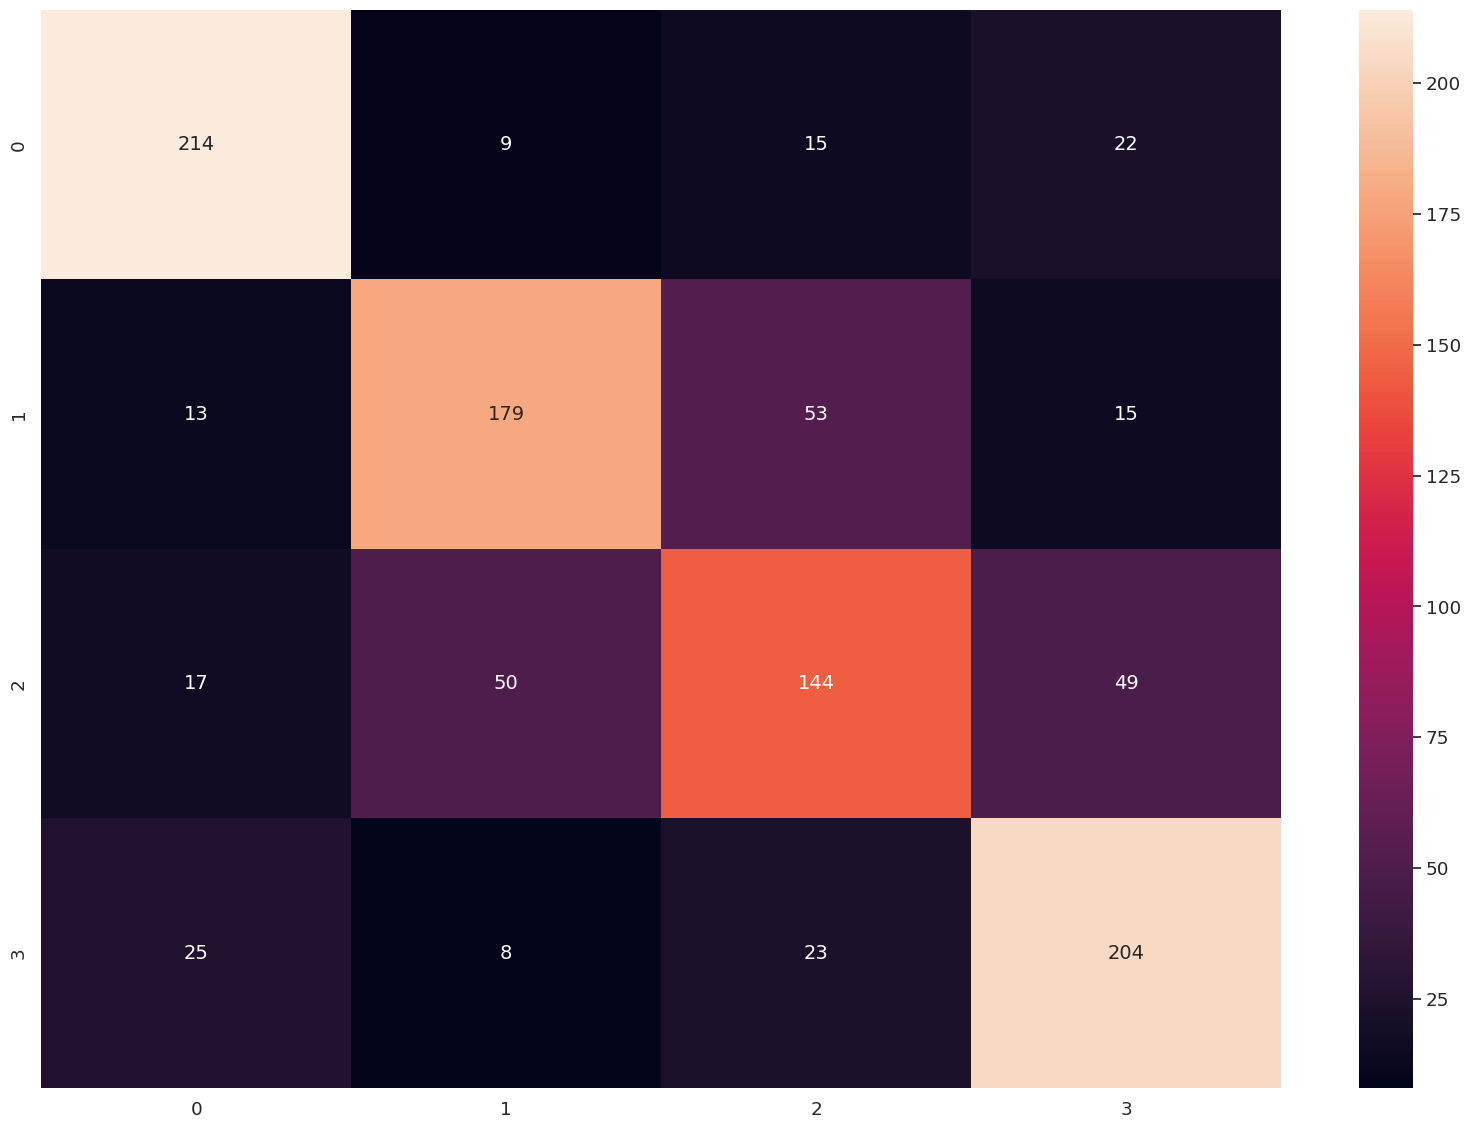

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm, range(4), range(4))
plt.figure(figsize=(20,14))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 14}, fmt='g') # for num predict size

plt.show()

In [ ]:
label_dict = output_tokenizer.word_index

In [ ]:
label = [key for key, value in label_dict.items()]

In [ ]:
print(classification_report(y_true, predicted_classes, target_names=label, digits=4))

              precision    recall  f1-score   support

         hig     0.7955    0.8231    0.8091       260
         pos     0.7276    0.6885    0.7075       260
         neg     0.6128    0.5538    0.5818       260
         bly     0.7034    0.7846    0.7418       260

    accuracy                         0.7125      1040
   macro avg     0.7098    0.7125    0.7101      1040
weighted avg     0.7098    0.7125    0.7101      1040

